In [335]:
import gillespy2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd

# Parameters used in the provided model
parameters_used = {
    'alphaA': 50,
    'alphaA_prime': 500,
    'alphaR': 0.01,
    'alphaR_prime': 50,
    'betaA': 50,
    'betaR': 5,
    'deltaMA': 10,
    'deltaMR': 0.5,
    'deltaA': 1,
    'deltaR': 0.2,
    'gammaA': 1,
    'gammaR': 1,
    'gammaC': 2,
    'thetaA': 50,
    'thetaR': 100
}

# Function to generate random parameters based on normal distribution
def generate_random_parameters(parameters_used, num_samples=1, std_dev=0.2):
    random_parameters = {}
    for parameter, value in parameters_used.items():
        # Calculate mean and standard deviation for the normal distribution
        mean = np.log10(value)
        std = abs(std_dev * mean)
        
        random_samples = np.random.normal(mean, std, num_samples)
        
        # Ensure generated parameters are positive
        random_samples = np.clip(random_samples, a_min=np.log10(1e-10), a_max=None)
        
        # Convert back to linear scale and string format
        random_parameters[parameter] = str(10 ** random_samples[0])
    
    return random_parameters

random_parameters = generate_random_parameters(parameters_used)

# Hysteresis model from Kut 2009/from Vilar 2002
def create_vilar_oscillator(alphaA, alphaA_prime, alphaR, alphaR_prime, betaA, betaR, deltaMA, deltaMR, deltaA, deltaR, gammaA, gammaR, gammaC, thetaA, thetaR):
    # Initialize Model
    model = gillespy2.Model(name="VilarOscillator")
    
    # Set System Volume
    model.volume = 1

    # Define Variables (GillesPy2.Species)
    Da = gillespy2.Species(name="Da", initial_value=1, mode="discrete")
    Da_prime = gillespy2.Species(name="Da_prime", initial_value=0, mode="discrete")
    Ma = gillespy2.Species(name="Ma", initial_value=0, mode="discrete")
    Dr = gillespy2.Species(name="Dr", initial_value=1, mode="discrete")
    Dr_prime = gillespy2.Species(name="Dr_prime", initial_value=0, mode="discrete")
    Mr = gillespy2.Species(name="Mr", initial_value=0, mode="discrete")
    C = gillespy2.Species(name="C", initial_value=0, mode="discrete")
    A = gillespy2.Species(name="A", initial_value=0, mode="discrete")
    R = gillespy2.Species(name="R", initial_value=0, mode="discrete")

    # Add Variables to Model
    model.add_species([Da, Da_prime, Ma, Dr, Dr_prime, Mr, C, A, R])

    # Define Parameters
    model.add_parameter([gillespy2.Parameter(name="alphaA", expression=str(alphaA)),
                         gillespy2.Parameter(name="alphaA_prime", expression=str(alphaA_prime)),
                         gillespy2.Parameter(name="alphaR", expression=str(alphaR)),
                         gillespy2.Parameter(name="alphaR_prime", expression=str(alphaR_prime)),
                         gillespy2.Parameter(name="betaA", expression=str(betaA)),
                         gillespy2.Parameter(name="betaR", expression=str(betaR)),
                         gillespy2.Parameter(name="deltaMA", expression=str(deltaMA)),
                         gillespy2.Parameter(name="deltaMR", expression=str(deltaMR)),
                         gillespy2.Parameter(name="deltaA", expression=str(deltaA)),
                         gillespy2.Parameter(name="deltaR", expression=str(deltaR)),
                         gillespy2.Parameter(name="gammaA", expression=str(gammaA)),
                         gillespy2.Parameter(name="gammaR", expression=str(gammaR)),
                         gillespy2.Parameter(name="gammaC", expression=str(gammaC)),
                         gillespy2.Parameter(name="thetaA", expression=str(thetaA)),
                         gillespy2.Parameter(name="thetaR", expression=str(thetaR))])

    # Define Reactions
    #bound and unbound of DA/DR
    r1 = gillespy2.Reaction(name="r1", reactants={'A': 1, 'Da': 1}, products={'Da_prime': 1}, rate="gammaA")
    r2 = gillespy2.Reaction(name="r2", reactants={'Da_prime': 1}, products={'A': 1, 'Da': 1}, rate="thetaA")
    r3 = gillespy2.Reaction(name="r3", reactants={'A': 1, 'Dr': 1}, products={'Dr_prime': 1}, rate="gammaR")
    r4 = gillespy2.Reaction(name="r4", reactants={'Dr_prime': 1}, products={'A': 1, 'Dr': 1}, rate="thetaR")
    #transcription
    r5 = gillespy2.Reaction(name="r5", reactants={'Da': 1}, products={'Da': 1, 'Ma': 1}, rate="alphaA")
    r6 = gillespy2.Reaction(name="r6", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'Ma': 1}, rate="alphaA_prime")
    r7 = gillespy2.Reaction(name="r7", reactants={'Dr': 1}, products={'Dr': 1, 'Mr': 1}, rate="alphaR")
    r8 = gillespy2.Reaction(name="r8", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'Mr': 1}, rate="alphaR_prime")
    #translation
    r9 = gillespy2.Reaction(name="r9", reactants={'Ma': 1}, products={'A': 1, 'Ma': 1}, rate="betaA")
    r10 = gillespy2.Reaction(name="r10", reactants={'Mr': 1}, products={'Mr': 1, 'R': 1}, rate="betaR")    
    #complex formation
    r11 = gillespy2.Reaction(name="r11", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate="gammaC")
    #degradation
    r12 = gillespy2.Reaction(name="r12", reactants={'A': 1}, products={}, rate="deltaA")
    r13 = gillespy2.Reaction(name="r13", reactants={'C': 1}, products={'R': 1}, rate="deltaA")
    r14 = gillespy2.Reaction(name="r14", reactants={'R': 1}, products={}, rate="deltaR")
    r15 = gillespy2.Reaction(name="r15", reactants={'Ma': 1}, products={}, rate="deltaMA")    
    r16 = gillespy2.Reaction(name="r16", reactants={'Mr': 1}, products={}, rate="deltaMR")

    # Add Reactions to Model
    model.add_reaction([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16])

    # Define Timespan
    tspan = gillespy2.TimeSpan.linspace(t=400, num_points=200)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

# Create the model using random parameters
model = create_vilar_oscillator(**random_parameters)
ode_results = model.run(algorithm="ODE")


In [336]:
# Calculate period from the time series data for one species (e.g., 'A')
species = 'A'
# Extract time series data
time_series = ode_results[0]['time']
concentration_series = ode_results[0][species]

# Find peaks in concentration series
peaks, _ = find_peaks(concentration_series, height=0)

# Compute period as the average time difference between consecutive peaks
period_lengths = np.diff(time_series[peaks])
period = np.mean(period_lengths)

print("Period of the oscillator:", period, "a.u.")


Period of the oscillator: 13.8191125 a.u.


In [337]:
# calculate deviation of genarated random variable from the original parameter used
def calculate_parameter_deviation(original_parameters, random_parameters):
    deviations = {}
    for parameter, original_value in original_parameters.items():
        random_value = float(random_parameters[parameter])
        deviation = abs(random_value - original_value) / original_value
        deviations[parameter] = deviation
    return deviations

# Calculate parameter deviations
parameter_deviations = calculate_parameter_deviation(parameters_used, random_parameters)

# Calculate total parameter deviation
total_deviation = sum(parameter_deviations.values())/16
print("Total parameter deviation:", total_deviation)


Total parameter deviation: 0.24467717449796147


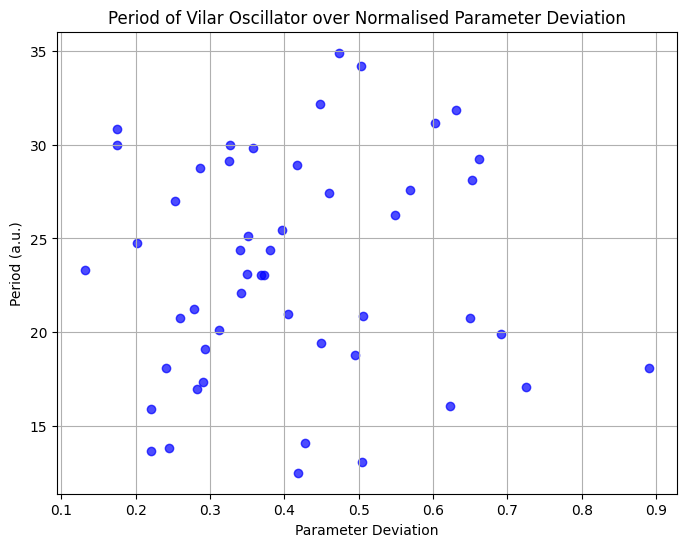

In [345]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Input data as a string
input_data = """20.10055,0.311366404
18.09045,0.240323583
34.170809,0.503223075
28.913762,0.416952533
24.371872,0.380715297
20.770517,0.259288698
32.16085,0.447814515
27.42285,0.459551541
16.080425,0.623055983
19.430483,0.449510999
17.085425,0.724687054
19.095475,0.293165436
23.115575,0.349899608
23.292938,0.131827723
27.566421,0.568647724
31.825825,0.630300965
16.954343,0.281727253
12.506997,0.418026217
13.66835,0.220902728
25.125625,0.350496764
18.760483,0.494828936
26.264663,0.549024129
34.901809,0.473055497
20.882161,0.50561844
22.110575,0.341465032
25.46066,0.396672075
29.99615,0.175186512
29.84153077,0.357229372
15.91291458,0.220520473
23.05646471,0.368929409
24.74874688,0.201392365
29.99614615,0.327267682
18.090475,0.890043645
20.77049444,0.650014932
24.37187188,0.340194634
28.75914615,0.286782689
20.99388333,0.404448311
14.070375,0.427868286
19.88889211,0.69151166
13.065325,0.503748479
17.35954318,0.290455474
21.21721944,0.277887552
30.82074167,0.17486979
26.99213571,0.252572828
29.14575,0.325644297
31.15574167,0.602962481
29.22306923,0.662207228
28.1407,0.652981451
23.05646765,0.372354876
13.8191125,0.244677174"""

# Read data from input string
data = pd.read_csv(StringIO(input_data), header=None, names=['Period', 'Parameter Deviation'], delimiter=',')

# Plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data['Parameter Deviation'], data['Period'], color='blue', alpha=0.7)
plt.title('Period of Vilar Oscillator over Normalised Parameter Deviation')
plt.xlabel('Parameter Deviation')
plt.ylabel('Period (a.u.)')
plt.grid(True)
plt.show()
